# Machine Learning Prognostics for Turbofan Engine Degradation Dataset

Information about the problem is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan and original data is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

The data was originally generated using the Commercial Modular Aero-Propulsion System Simulations (C-MAPPS) system.

The approach used in the turbofan engine degradation dataset was then used in the PHM08 challenge.  Information about other research on the C-MAPSS data is available at  https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_063.pdf


In [6]:
import h2o
import numpy as np
import pandas as pd
import seaborn as sns
import pykalman as pyk
%matplotlib inline
sns.set()
doGridSearch = False

# Preprocessing

In [45]:
# Input files don't have column names
dependent_vars = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And we are going to add these columns
kalman_smoothed_mean_columns_names =["SensorMeasureKalmanMean"+str(i) for i in range(1,22)]

### Read in the raw files

In [46]:
train = pd.read_csv("train_FD001.txt", sep=r"\s*", header=None,
                   names=input_file_column_names, engine='python')
test  = pd.read_csv("test_FD001.txt",  sep=r"\s*", header=None,
                   names=input_file_column_names, engine='python')
test_rul = pd.read_csv("RUL_FD001.txt", header=None, names=['RemainingUsefulLife'])
test_rul.index += 1  # set the index to be the unit number in the test data set
test_rul.index.name = "UnitNumber"

### Calculate Remaining Useful Life in T-minus notation for the training data
This puts all data on the same basis for supervised training

In [47]:
# Calculate the remaining useful life for each training sample based on last measurement being zero remaining
grouped_train = train.groupby('UnitNumber', as_index=False)
useful_life_train = grouped_train.agg({'Cycle' : np.max })
useful_life_train.rename(columns={'Cycle': 'UsefulLife'}, inplace=True)
train_wfeatures = pd.merge(train, useful_life_train, on="UnitNumber")
train_wfeatures["RemainingUsefulLife"] = -(train_wfeatures.UsefulLife - train_wfeatures.Cycle)
train_wfeatures.drop('UsefulLife', axis=1, inplace=True)

## Exploratory Data Analysis

Look at how the sensor measures evolve over time (first column) as well as how they relate to each other for a subset of the units.

These features were the top 3 and bottom 2 most important sensor features as discovered by H2O's GBM, later in the notebook.

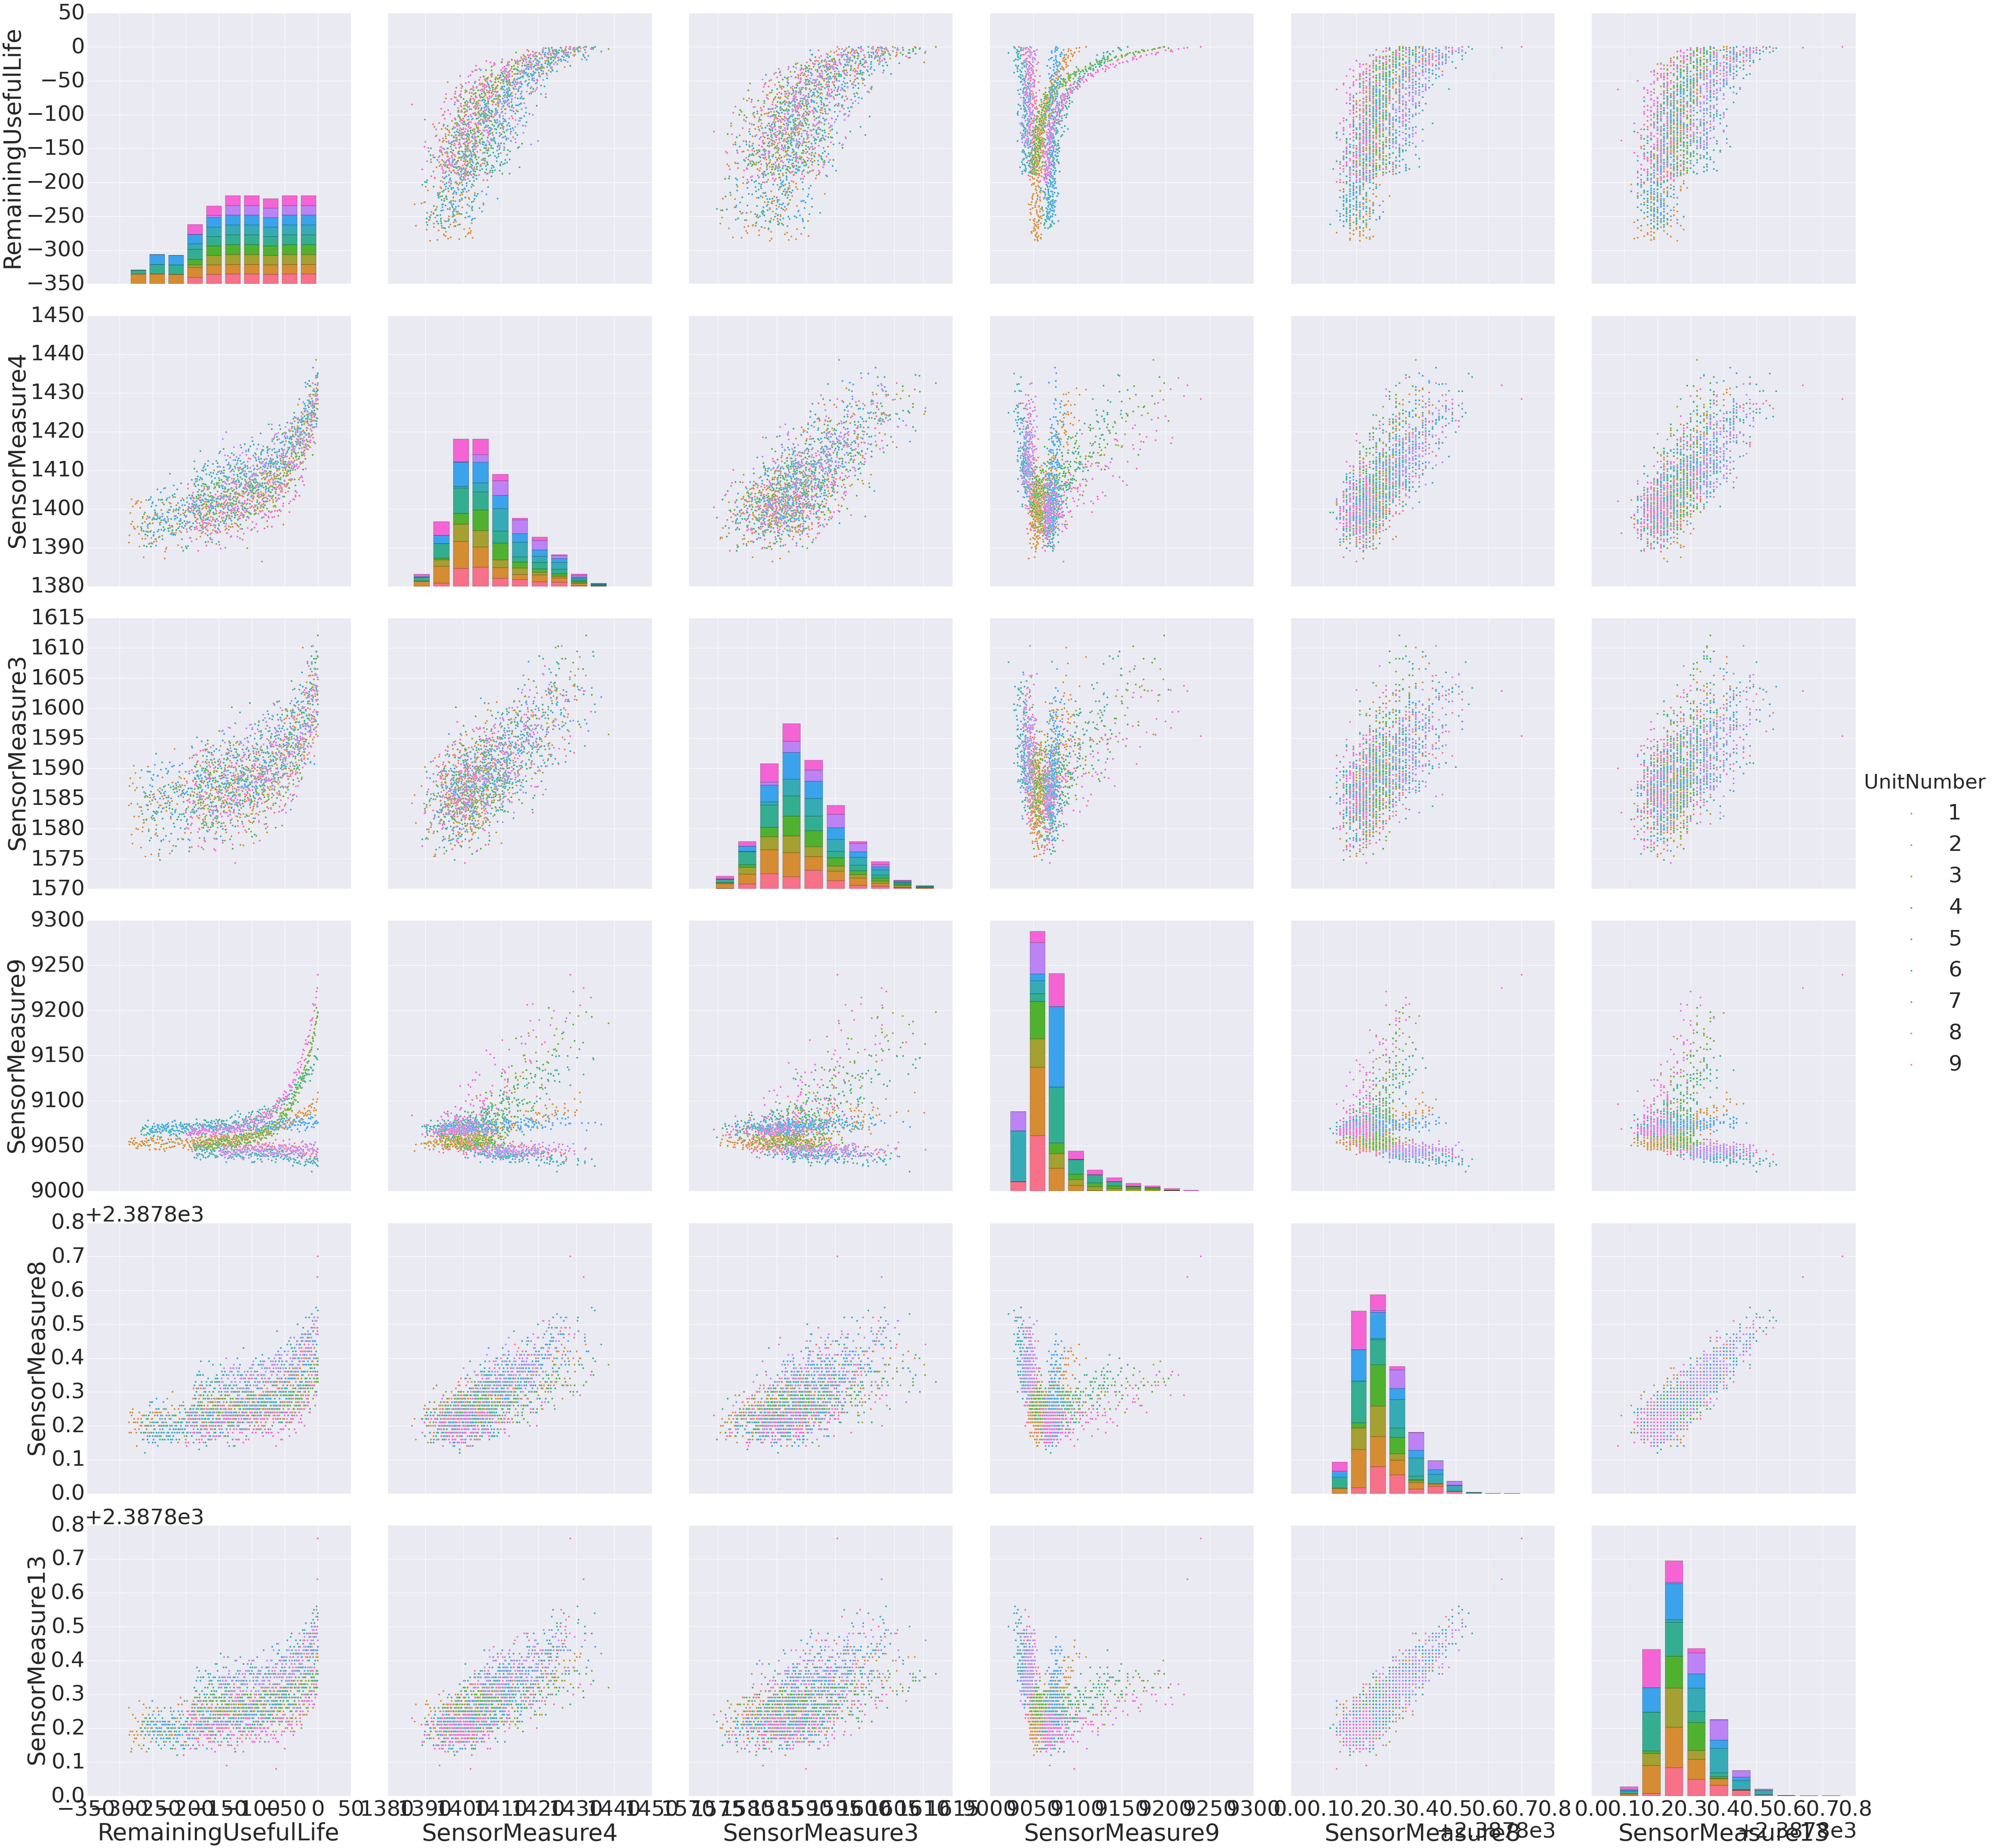

In [48]:
sns.set_context("notebook", font_scale=5)
p = sns.pairplot(train_wfeatures.query('UnitNumber < 10'),
                 vars=["RemainingUsefulLife", "SensorMeasure4", "SensorMeasure3",
                       "SensorMeasure9", "SensorMeasure8", "SensorMeasure13"], size=10,
                 hue="UnitNumber", palette=sns.color_palette("husl", 9));

### Signal processing using Kalman smoothing filter
Kalman parameters were determined using EM algorithm and then those parameters are used for smoothing the signal data.

This is applied repeatedly to each Unit, in both the training and test set.

In [11]:
kalman_smoothed_mean_columns_names =["SensorMeasureKalmanMean"+str(i) for i in range(1,22)]

def calcSmooth(measures):
    kf = pyk.KalmanFilter(initial_state_mean=measures[0], n_dim_obs=measures.shape[1])
    (smoothed_state_means, smoothed_state_covariances) = kf.em(measures).smooth(measures)
    return smoothed_state_means

def filterEachUnit(df):
    dfout = df.copy()
    
    for newcol in kalman_smoothed_mean_columns_names:
        dfout[newcol] = np.nan
    
    for unit in dfout.UnitNumber.unique():
        print 'Processing Unit: ' + str(unit)
        unitmeasures = dfout[dfout.UnitNumber == unit][sensor_measure_columns_names]
        smoothed_state_means = calcSmooth( np.asarray( unitmeasures ) )
        dfout.loc[dfout.UnitNumber == unit, kalman_smoothed_mean_columns_names] = smoothed_state_means
        print 'Finished   Unit: ' + str(unit)
        
    return dfout   

processing training
Processing Unit: 1
Finished   Unit: 1
Processing Unit: 2
Finished   Unit: 2
Processing Unit: 3
Finished   Unit: 3
Processing Unit: 4
Finished   Unit: 4
Processing Unit: 5
Finished   Unit: 5
Processing Unit: 6
Finished   Unit: 6
Processing Unit: 7
Finished   Unit: 7
Processing Unit: 8
Finished   Unit: 8
Processing Unit: 9
Finished   Unit: 9
Processing Unit: 10
Finished   Unit: 10
Processing Unit: 11
Finished   Unit: 11
Processing Unit: 12
Finished   Unit: 12
Processing Unit: 13
Finished   Unit: 13
Processing Unit: 14
Finished   Unit: 14
Processing Unit: 15
Finished   Unit: 15
Processing Unit: 16
Finished   Unit: 16
Processing Unit: 17
Finished   Unit: 17
Processing Unit: 18
Finished   Unit: 18
Processing Unit: 19
Finished   Unit: 19
Processing Unit: 20
Finished   Unit: 20
Processing Unit: 21
Finished   Unit: 21
Processing Unit: 22
Finished   Unit: 22
Processing Unit: 23
Finished   Unit: 23
Processing Unit: 24
Finished   Unit: 24
Processing Unit: 25
Finished   Unit: 2

### Output the results to files
Helps so preprocessing only has to be done once.

In [12]:
# Get picky about the order of output columns
test_output_cols = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names + \
                   kalman_smoothed_mean_columns_names
train_output_cols = test_output_cols + dependent_vars

train_output = train_wkalman[train_output_cols]
test_output = test_wkalman[test_output_cols]

In [15]:
# Output the files, so we don't have to do the preprocessing again.
train_output.to_csv("train_FD001_preprocessed.csv", index=False)
test_output.to_csv("test_FD001_preprocessed.csv", index=False)
test_rul.to_csv("rul_FD001_preprocessed.csv", index=True)

# Modeling

### Startup H2O

In [3]:
h2o.init()

H2O cluster uptime:,22 hours 43 minutes 56 seconds 599 milliseconds
H2O cluster version:,3.1.0.3144
H2O cluster name:,H2ODemo
H2O cluster total nodes:,1
H2O cluster total memory:,192.19 GB
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


### Load training and final test data into H2O

In [4]:
train_hex = h2o.import_file("/home/ec2-user/python-examples/cmapdata/train_FD001_preprocessed.csv")
test_hex = h2o.import_file("/home/ec2-user/python-examples/cmapdata/test_FD001_preprocessed.csv")


Parse Progress: [##################################################] 100%
Imported /home/ec2-user/python-examples/cmapdata/train_FD001_preprocessed.csv. Parsed 20,631 rows and 48 cols

Parse Progress: [##################################################] 100%
Imported /home/ec2-user/python-examples/cmapdata/test_FD001_preprocessed.csv. Parsed 13,096 rows and 47 cols


### Setup independent and dependent features

Use the operational settings and Kalman smoothed mean states as the independent features

Setup a fold column to great cross validation models from 90 units and cross validating on 10 units.  This creates a 10-fold cross validation.  The cross validation models are then used to create an ensemble model for predictions

In [5]:
xCols= operational_settings_columns_names + kalman_smoothed_mean_columns_names
yCol = dependent_vars

foldCol = "UnitNumberMod10"
train_hex[foldCol] = train_hex["UnitNumber"] % 10

### Train a series of GLM Models using Grid Search over $\alpha$ and $\lambda$

In [8]:
def trainGLM(x, y, fold_column, alpha=0.5, penalty=1e-5):
    return h2o.glm(x=x, y=y,fold_column=fold_column,family = "gaussian",alpha = [alpha], Lambda = [penalty])

def gridSearchGLM(x, y, fold_column, alphas = [0,0.5,1], penalties=np.logspace(-3,0,num=4)):
    results = []
    for alpha in alphas:
        for penalty in penalties:
            results.append( trainGLM(x, y, fold_column, alpha, penalty) )
    return results

if doGridSearch:
    glmModels = gridSearchGLM(train_hex[xCols] ,  train_hex[yCol] , train_hex[foldCol])
else:
    # this is used to speed up the demonstration by just building the single model previously found
    glmModels = [ trainGLM(train_hex[xCols] ,  train_hex[yCol] , train_hex[foldCol], alpha=1, penalty=0.01 )]


glm Model Build Progress: [##################################################] 100%


### Extract the 'best' model

Uses model with lowest MSE on the cross validation data.  

This is a reasonable substitute for using the final scoring method.

In [9]:
def extractBestModel(models):
    bestMse = models[0].mse(xval=True)
    result = models[0]
    for model in models:
        if model.mse(xval=True) < bestMse:
            bestMse = model.mse(xval=True)
            result = model
    return result

bestModel = extractBestModel(glmModels)
bestModel

Model Details
H2ORegressionModel :  Generalized Linear Model
Model Key:  GLM_model_python_1440713403955_192
       family      link          regularization  number_of_predictors_total  \
0    gaussian  identity  Lasso (lambda = 0.01 )                          17   

   number_of_active_predictors  number_of_iterations  \
0                           18                     1   

                           training_frame  
0  py25b1aa81-2cb0-4252-85a0-89e8a429bfc4  


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1907.00855358
R^2: 0.598047319685
Mean Residual Deviance: 1907.00855358
Null degrees of freedom: 20630
Residual degrees of freedom: 20613
Null deviance: 97880908.3648
Residual deviance: 39343493.4689
AIC: 214418.190254

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1980.32797333
R^2: 0.582593305473
Mean Residual Deviance: 1980.32797333
Null degrees of freedom: 20630
Residual degrees of freedom: 20614
Null deviance: 98171005.090

### Build a series of GBM models using grid search for hyper-parameters

Extract the 'best' model using the same approach as with GLM.

In [10]:
def trainGBM(x, y, fold_column, learning_rate=0.1, ntrees=50, max_depth=5):
    return h2o.gbm(x=x, y=y,fold_column=fold_column,distribution = "gaussian",
                   learn_rate=learning_rate, ntrees=ntrees, max_depth=max_depth)

def gridSearchGBM(x, y, fold_column, learning_rates = [0.1,0.03,0.01], ntrees=[10,30,100,300], max_depth=[1,3,5]):
    results = []
    for learning_rate in learning_rates:
        for ntree in ntrees:
            for depth in max_depth:
                print "GBM: {learning rate: "+str(learning_rate)+"},{ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"}"
                results.append( trainGBM(x, y, fold_column, learning_rate=learning_rate, ntrees=ntree, max_depth=depth) )
    return results

In [25]:
if doGridSearch:
    gbmModels = gridSearchGBM(train_hex[xCols] ,  train_hex[yCol] , train_hex[foldCol], \
                              learning_rates=[0.03,0.01,0.003], ntrees=[100,300,1000,3000], max_depth=[1,2,3,5])
else:
    gbmModels = [trainGBM(train_hex[xCols] ,  train_hex[yCol] , train_hex[foldCol], \
                        learning_rate=0.01, ntrees=300, max_depth=5)]


gbm Model Build Progress: [##################################################] 100%


In [26]:
bestGbmModel = extractBestModel(gbmModels)

Best model had depth 5, learning rate 0.01, and 300 trees

In [27]:
bestGbmModel.params

{u'balance_classes': {'actual': False, 'default': False},
 u'build_tree_one_node': {'actual': False, 'default': False},
 u'checkpoint': {'actual': None, 'default': None},
 u'class_sampling_factors': {'actual': None, 'default': None},
 u'distribution': {'actual': u'gaussian', 'default': u'AUTO'},
 u'fold_assignment': {'actual': u'AUTO', 'default': u'AUTO'},
 u'fold_column': {'actual': {u'__meta': {u'schema_name': u'ColSpecifierV3',
    u'schema_type': u'VecSpecifier',
    u'schema_version': 3},
   u'column_name': u'UnitNumberMod10',
   u'is_member_of_frames': None},
  'default': None},
 u'ignore_const_cols': {'actual': True, 'default': True},
 u'ignored_columns': {'actual': None, 'default': None},
 u'keep_cross_validation_predictions': {'actual': False, 'default': False},
 u'learn_rate': {'actual': 0.01, 'default': 0.1},
 u'max_after_balance_size': {'actual': 5.0, 'default': 5.0},
 u'max_confusion_matrix_size': {'actual': 20, 'default': 20},
 u'max_depth': {'actual': 5, 'default': 5},
 

Best GBM Model reported MSE on cross validation data as 1687, an improvement from GLM of 1954.

In [28]:
bestGbmModel

Model Details
H2ORegressionModel :  Gradient Boosting Machine
Model Key:  GBM_model_python_1440713403955_198
     number_of_trees  model_size_in_bytes  min_depth  max_depth  mean_depth  \
0                300               127643          5          5           5   

   min_leaves  max_leaves  mean_leaves  
0          27          32        31.14  


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1263.01741073
R^2: 0.733785549847
Mean Residual Deviance: 1263.01741073

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1687.76946954
R^2: 0.644257777049
Mean Residual Deviance: 1687.76946954
                 timestamp           duration  number_of_trees  training_MSE  \
0      2015-08-28 21:10:39   2 min  7.130 sec                1   4682.171706   
1      2015-08-28 21:10:40   2 min  7.483 sec                2   4621.187364   
2      2015-08-28 21:10:40   2 min  7.806 sec                3   4561.445414   
3      2015-08-28 21:10:40   2 min  8.086 se

### Exploratory model analysis

See how well the models do predicting on the training set.  Should be pretty good, but often worth a check.  

Predictions are an ensemble of the 10-fold cross validation models.

In [29]:
train_hex["weights"] = 1
allModels = bestGbmModel.xvals
pred = sum([model.predict(train_hex) for model in allModels]) / len(allModels)

In [30]:
pred["actual"] = train_hex["RemainingUsefulLife"]
pred["unit"] = train_hex["UnitNumber"]

### Plot actual remaining useful life vs predicted remaining useful life

Ideally all points would be on the diagonal, indication prediction from data matched exactly the actual.

Also, it is important that the prediction gets more accurate the closer it gets to no useful life remaining.

Looking at a sample of the first 12 units.

Moved predictions from H2O to Python Pandas for plotting using Seaborn.

In [31]:
scored_df = pred.as_data_frame(use_pandas=True)

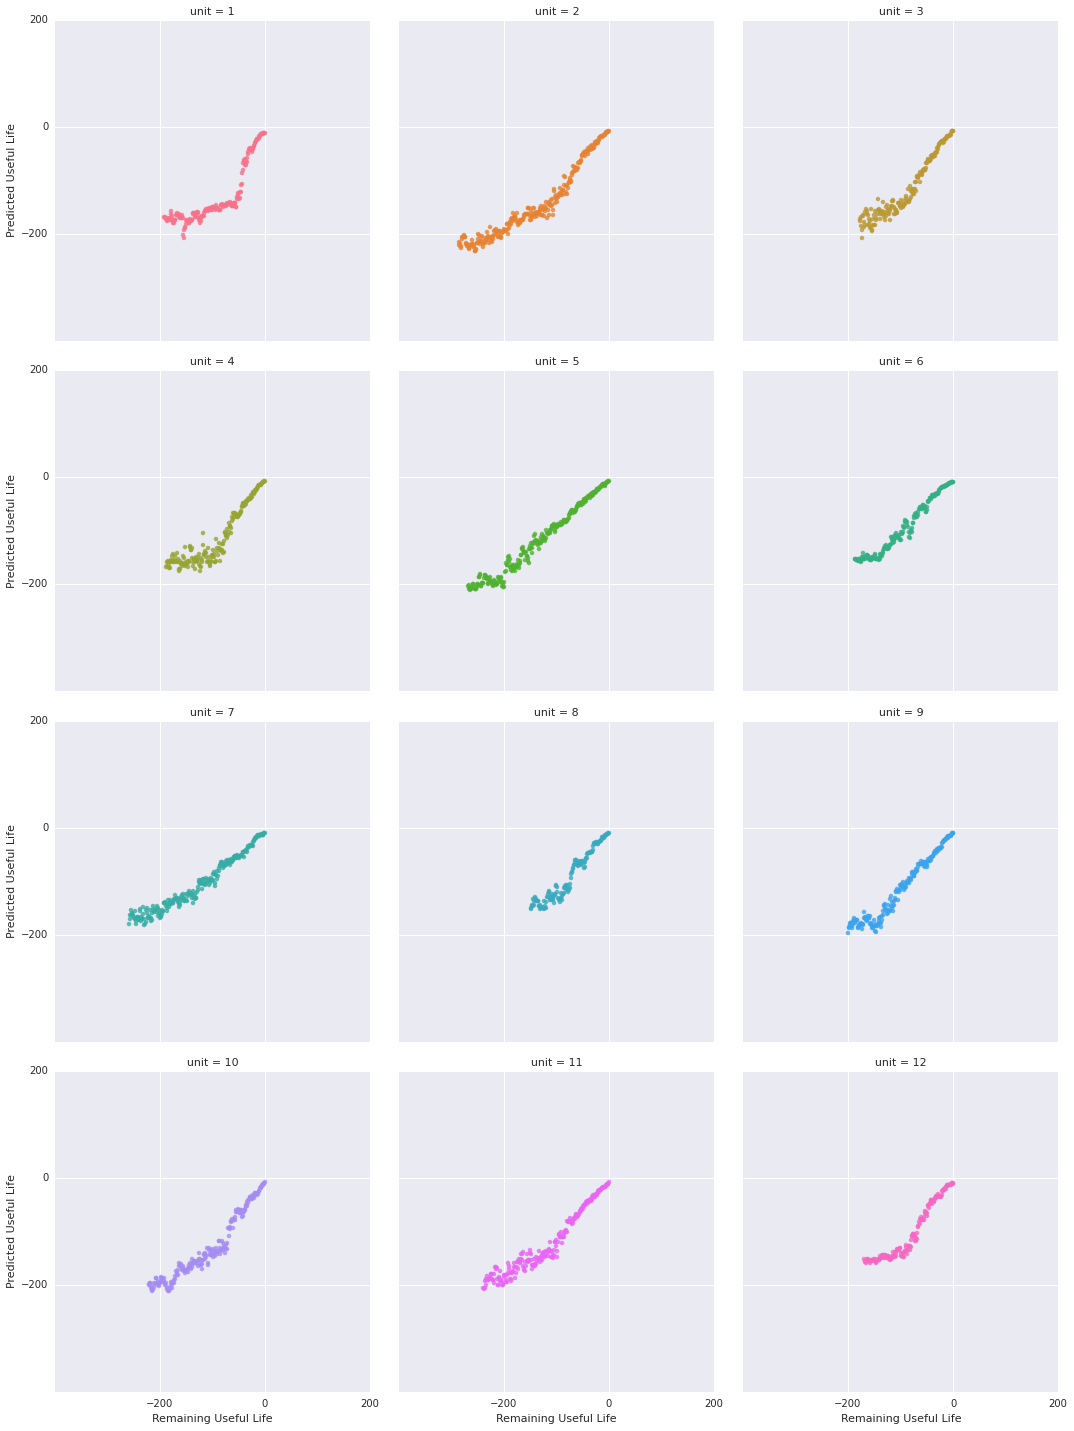

In [32]:
g=sns.lmplot(x="actual",y="predict",hue="unit",col="unit",data=scored_df[scored_df.unit < 13],col_wrap=3,fit_reg=False)

g = (g.set_axis_labels("Remaining Useful Life", "Predicted Useful Life")
      .set(xlim=(-400, 200), ylim=(-400, 200),
           xticks=[-200, 0, 200], yticks=[-200, 0, 200]))

# Model prediction and assessment

### Predict on the hold-out test set, using an average of all the cross validation models.

In [34]:
testPreds = sum([model.predict(test_hex) for model in allModels]) / len(allModels)

Append the original index information (Cycle and UnitNumber) to the predicted values so we have them later.

In [35]:
testPreds["Cycle"] = test_hex["Cycle"]
testPreds["UnitNumber"] = test_hex["UnitNumber"]

Move the predictions over to Python Pandas for final analysis and scoring

In [36]:
testPreds_df = testPreds.as_data_frame(use_pandas=True)

Load up the actual Remaining Useful Life information.

In [39]:
actual_RUL = pd.read_csv("/home/ec2-user/python-examples/cmapdata/rul_FD001_preprocessed.csv")

The final scoring used in the competition is based on a single value per unit.  We extract the last three predictions and use the mean of those (simple aggregation) and put the prediction back from remaining useful life in T-minus format to cycles remaining (positive).

In [37]:
def aggfunc(x):
    return np.mean( x.order().tail(rows=3,show=False) )

grouped_by_unit_preds = testPreds_df.groupby("UnitNumber", as_index=False)
predictedRUL = grouped_by_unit_preds.agg({'predict' : aggfunc })
predictedRUL.predict = -predictedRUL.predict

Add the prediction to the actual data frame, and use the scoring used in the PHMO8 competition (more penality for predicting more useful life than there is actual).

In [40]:
final = pd.concat([actual_RUL, predictedRUL.predict], axis=1)

In [41]:
def rowScore(row):
    d = row.predict-row.RemainingUsefulLife
    return np.exp( -d/10 )-1 if d < 0 else np.exp(d/13)-1

rowScores = final.apply(rowScore, axis=1)

This is the final score using PHM08 method of scoring.

In [42]:
sum(rowScores)

919.94687507011963

### Finally look at the actual remaining useful life and compare to predicted

Some things that should ideally would be true:
- As RUL gets closer to zero, the prediction gets closer to actual

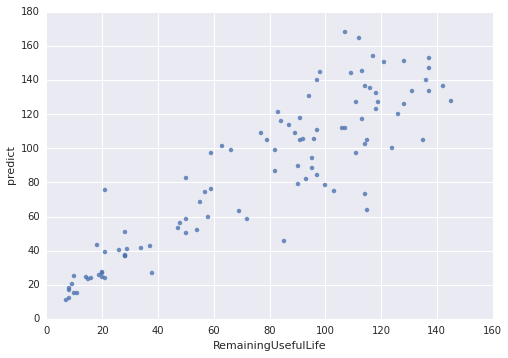

In [43]:
sns.regplot("RemainingUsefulLife", "predict", data=final, fit_reg=False);
